# **APPLICATION OF DEEP LEARNING IN PREDICTING YIELD CURVES**

In [1]:
# Load libraries
# Global Libraries
# Disable the warnings
import warnings

# Time series Models
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Plotting
import seaborn as sns

# Libraries for Statistical Models
import statsmodels.api as sm
from matplotlib import pyplot
from pandas.plotting import scatter_matrix

# Regression ML
from sklearn.linear_model import LinearRegression

# Loss Function
from sklearn.metrics import mean_squared_error

# Modeling
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings("ignore")

In [2]:
# downloading the data
start = datetime(2007, 6, 30)
end = datetime(2022, 6, 30)

data = [
    "DGS1MO",
    "DGS3MO",
    "DGS1",
    "DGS2",
    "DGS5",
    "DGS7",
    "DGS10",
    "DGS30",
    "TREAST",  # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
    "FYGFDPUN",  # -- Federal Debt Held by the Public ( Millions of Dollars )
    "FDHBFIN",  # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
    "GFDEBTN",  # -- Federal Debt: Total Public Debt ( Millions of Dollars )
    "BAA10Y",  # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
]
data = web.DataReader(data, "fred", start, end).dropna(how="all").ffill()
data["FDHBFIN"] = data["FDHBFIN"] * 1000
data["GOV_PCT"] = data["TREAST"] / data["GFDEBTN"]
data["HOM_PCT"] = data["FYGFDPUN"] / data["GFDEBTN"]
data["FOR_PCT"] = data["FDHBFIN"] / data["GFDEBTN"]

In [3]:
data.rename(
    columns={
        "DGS1MO": "1m",
        "DGS3MO": "3m",
        "DGS1": "1y",
        "DGS2": "2y",
        "DGS5": "5y",
        "DGS7": "7y",
        "DGS10": "10y",
        "DGS30": "30y",
    },
    inplace=True,
)
return_period = 5

Y = data.loc[:, ["1m", "5y", "30y"]].shift(-return_period)
Y.columns = [col + "_pred" for col in Y.columns]

X = data.loc[
    :,
    [
        "1m",
        "3m",
        "1y",
        "2y",
        "5y",
        "7y",
        "10y",
        "30y",
        "GOV_PCT",
        "HOM_PCT",
        "FOR_PCT",
        "BAA10Y",
    ],
]

df = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = df.loc[:, Y.columns]
X = df.loc[:, X.columns]

df.head(10)

,1m_pred,5y_pred,30y_pred,1m,3m,1y,2y,5y,7y,10y,30y,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2007-07-04,4.73,4.98,5.18,4.77,4.95,4.98,4.89,4.95,4.99,5.05,5.14,0.087765,0.56055,0.248156,1.60
2007-07-11,4.77,4.91,5.10,4.73,4.95,4.99,4.89,4.98,5.02,5.09,5.18,0.087770,0.56055,0.248156,1.59
2007-07-18,5.04,4.80,5.04,4.77,4.96,4.98,4.84,4.91,4.95,5.02,5.10,0.087776,0.56055,0.248156,1.58
2007-07-25,5.05,4.60,4.90,5.04,4.99,4.95,4.74,4.80,4.85,4.92,5.04,0.087782,0.56055,0.248156,1.65
2007-08-01,5.04,4.69,5.01,5.05,4.89,4.82,4.56,4.60,4.66,4.76,4.90,0.087792,0.56055,0.248156,1.86
2007-08-08,4.18,4.41,5.00,5.04,4.95,4.89,4.64,4.69,4.75,4.84,5.01,0.087794,0.56055,0.248156,1.87
2007-08-15,3.12,4.34,4.96,4.18,4.21,4.41,4.27,4.41,4.52,4.69,5.00,0.087659,0.56055,0.248156,2.03
2007-08-22,4.02,4.31,4.88,3.12,3.67,4.10,4.15,4.34,4.46,4.63,4.96,0.087661,0.56055,0.248156,2.07
2007-08-29,4.28,4.20,4.79,4.02,3.98,4.24,4.14,4.31,4.41,4.57,4.88,0.087108,0.56055,0.248156,2.05


In [4]:
df.shape

(756, 15)

This data has 243 observations and 15 variables.

In [5]:
df.describe()

,1m_pred,5y_pred,30y_pred,1m,3m,1y,2y,5y,7y,10y,30y,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.614828,1.738545,3.165886,0.619603,0.667989,0.867579,1.079921,1.740807,2.112513,2.449008,3.168307,0.111527,0.702420,0.303741,2.692606
std,0.955767,0.859650,0.885398,0.967441,0.978962,1.002382,0.945499,0.865833,0.850942,0.876473,0.888289,0.037446,0.059761,0.029200,0.771027
min,0.000000,0.210000,0.990000,0.000000,0.000000,0.040000,0.110000,0.210000,0.390000,0.540000,0.990000,0.042643,0.556527,0.242635,1.560000
25%,0.040000,1.145000,2.630000,0.040000,0.050000,0.150000,0.340000,1.145000,1.467500,1.840000,2.630000,0.091391,0.678839,0.287594,2.190000
50%,0.110000,1.650000,3.045000,0.110000,0.140000,0.370000,0.750000,1.650000,2.060000,2.370000,3.045000,0.111571,0.719631,0.304740,2.600000
75%,0.962500,2.282500,3.790000,0.962500,1.070000,1.492500,1.580000,2.282500,2.710000,2.960000,3.792500,0.130192,0.733350,0.330286,3.020000
max,5.050000,4.980000,5.180000,5.050000,4.990000,4.990000,4.890000,4.980000,5.020000,5.090000,5.180000,0.191040,0.786267,0.341355,6.110000


We now plot the predicted variables to observe their behavior.

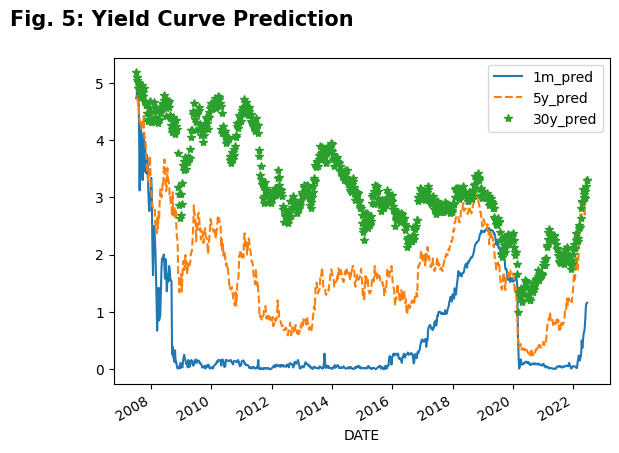

In [6]:
# print('\033[1m' + 'Fig 5: Yield Curve Prediction' + '\033[0m' )
Y.plot(style=["-", "--", "*"])
pyplot.suptitle(
    "Fig. 5: Yield Curve Prediction",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

<Figure size 1500x1500 with 0 Axes>

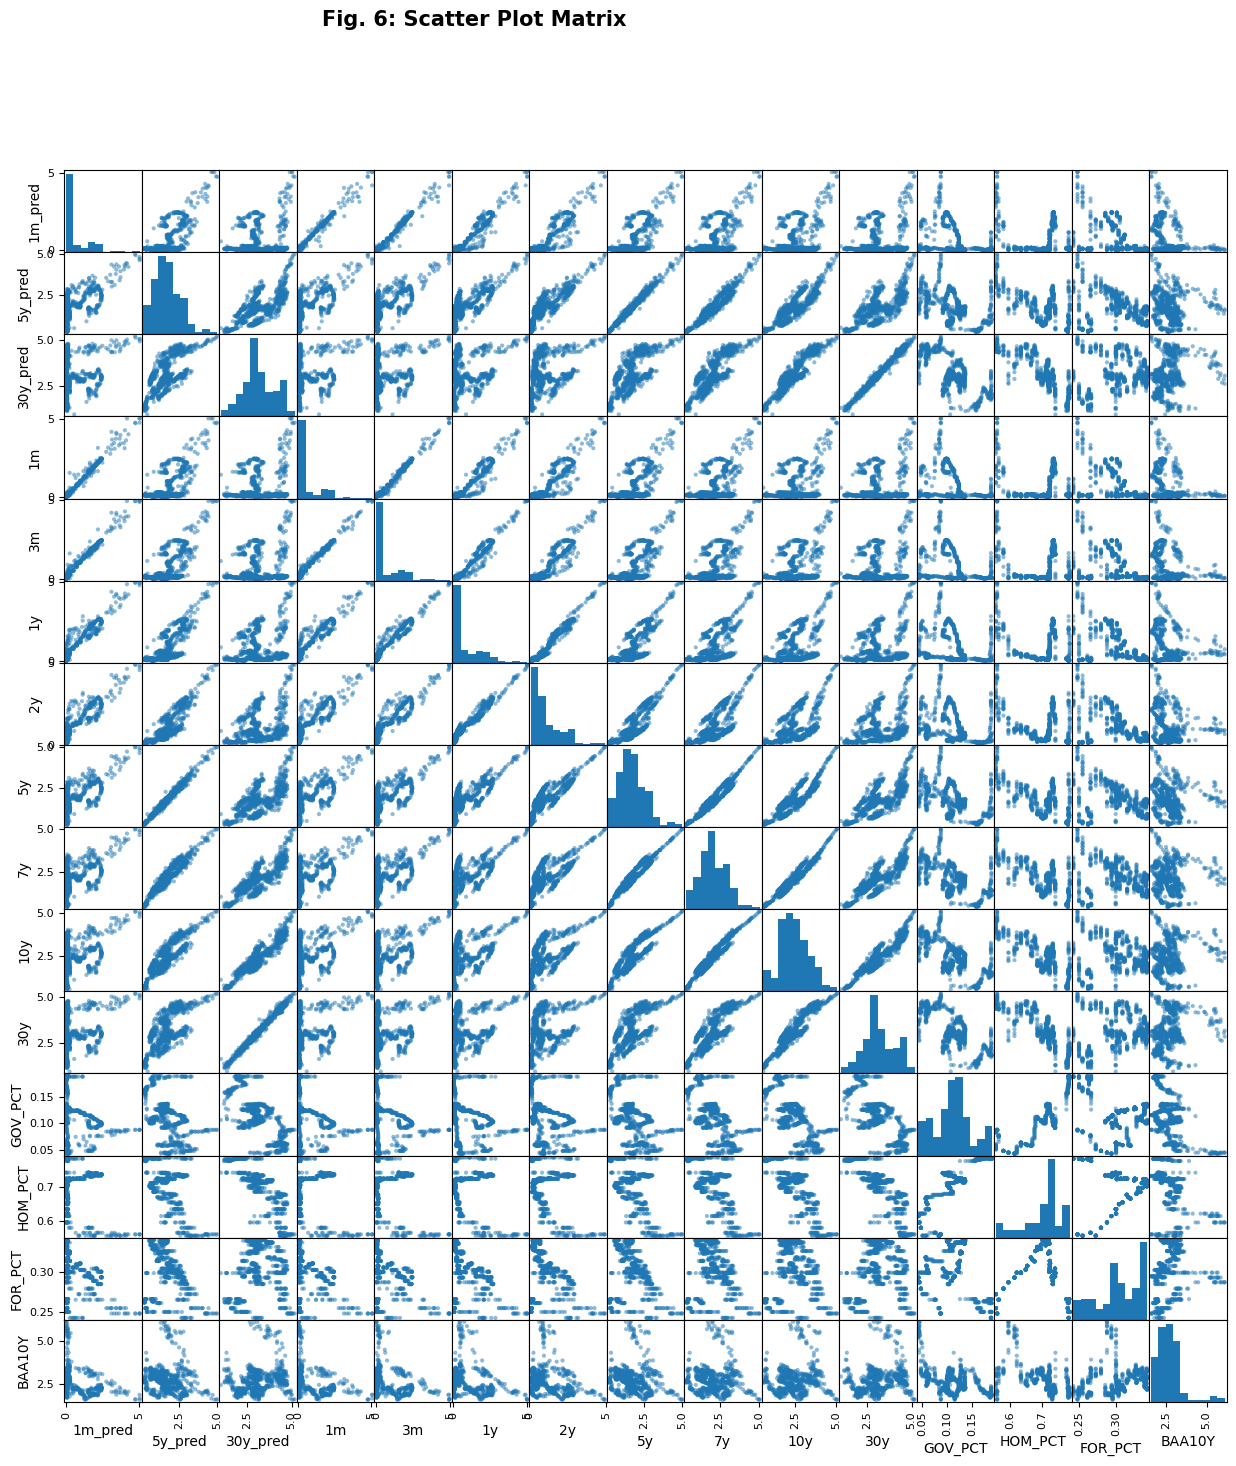

In [7]:
# Scatterplot Matrix
pyplot.figure(figsize=(15, 15))
scatter_matrix(df, figsize=(15, 16))
pyplot.suptitle(
    "Fig. 6: Scatter Plot Matrix",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

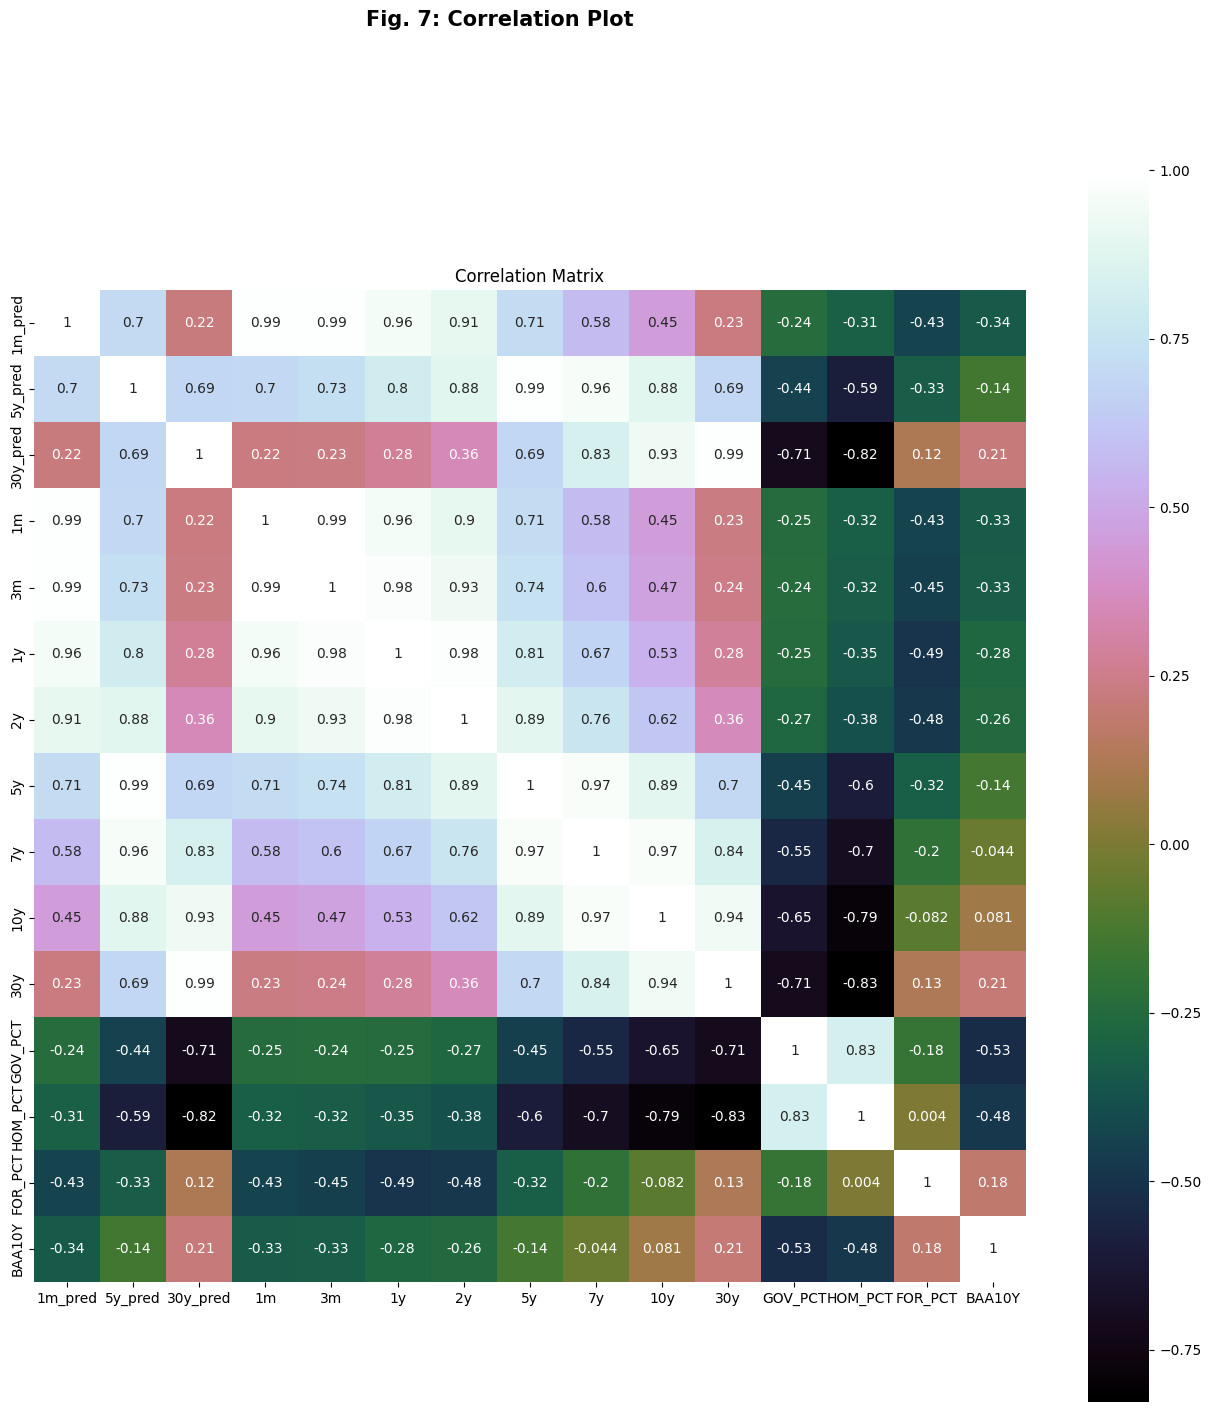

In [8]:
# correlation
correlation = df.corr()
pyplot.figure(figsize=(16, 16))
pyplot.title("Correlation Matrix")
pyplot.suptitle(
    "Fig. 7: Correlation Plot",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap="cubehelix")
pyplot.show()

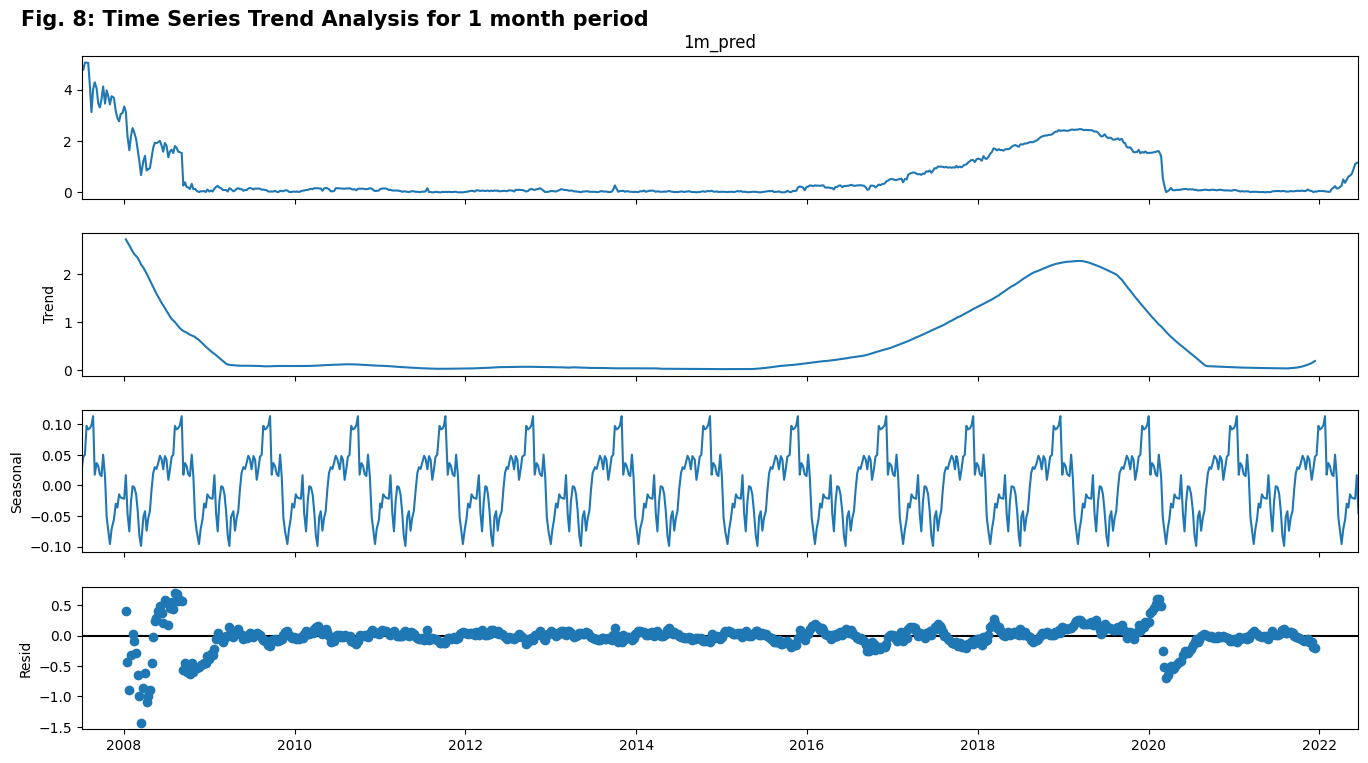

In [9]:
temp_Y = df["1m_pred"]
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.suptitle(
    "Fig. 8: Time Series Trend Analysis for 1 month period",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

Then, the 5-year analysis:

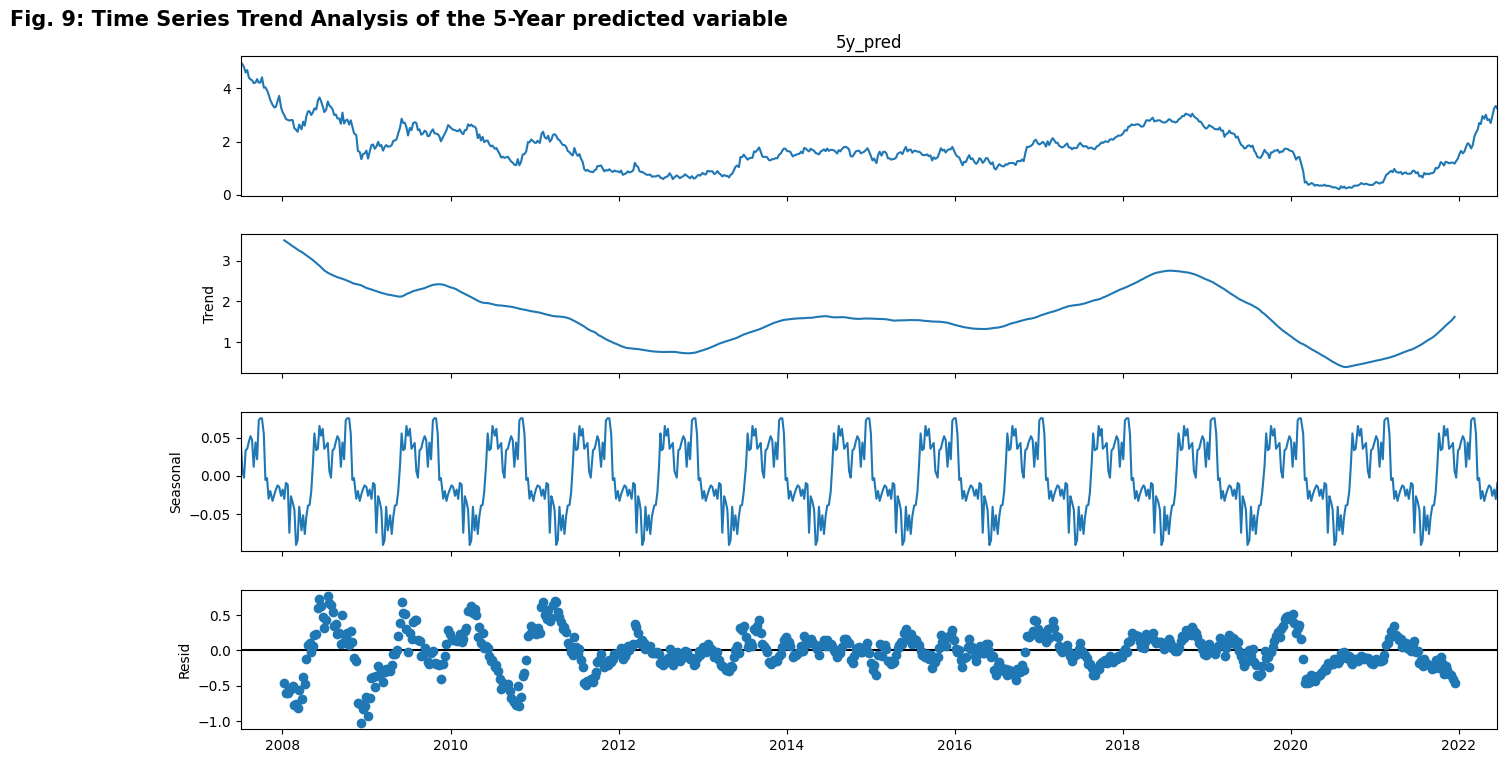

In [10]:
temp_Y = df["5y_pred"]
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.suptitle(
    "Fig. 9: Time Series Trend Analysis of the 5-Year predicted variable",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

Finally, the 30-year variable

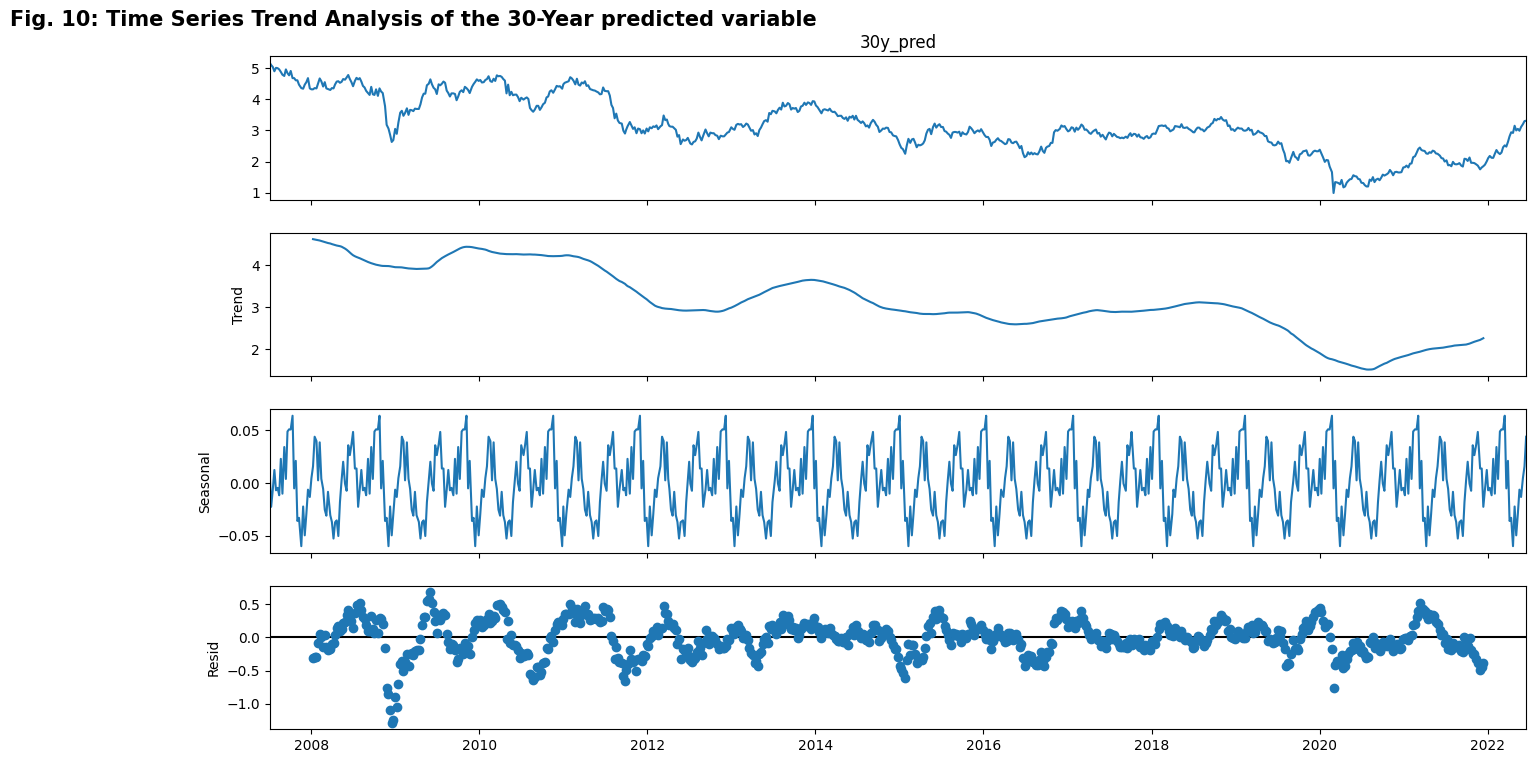

In [11]:
temp_Y = df["30y_pred"]
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.suptitle(
    "Fig. 10: Time Series Trend Analysis of the 30-Year predicted variable",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

In [12]:
# split out validation dataset for model validation
test_size = 0.2

seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)

We use cross-validation to validate the model while training on the limited data sample.

In [13]:
# test options for regression
num_folds = 10
scoring = "neg_mean_squared_error"

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

MSE = mean_squared_error(y_test, pred)

print("linear regression mean squared error:", MSE)

linear regression mean squared error: 0.01546723322935402


In [15]:
# Quadratic
poly = PolynomialFeatures(degree=2)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)

model = lr.fit(X_train2, y_train)
print(
    "quadratic regression mean squared error:",
    mean_squared_error(y_test, model.predict(X_test2)),
)

# Cubic
poly = PolynomialFeatures(degree=3)
X_train3 = poly.fit_transform(X_train)
X_test3 = poly.fit_transform(X_test)

model = lr.fit(X_train3, y_train)
print(
    "degree 3 polynomial regression mean squared error:",
    mean_squared_error(y_test, model.predict(X_test3)),
)

quadratic regression mean squared error: 0.03929743040563507
degree 3 polynomial regression mean squared error: 3.1772129690232624


In [16]:
from nnv import NNV

print("\033[1m" + "Fig 12: A Two Layer Neural Network" + "\033[0m")
layersList = [
    {"title": "inputs \n + bias", "units": 12, "color": "darkBlue"},
    {"title": "hidden layer", "units": 20},
    # {"title":"$f(z)$", "units": 1, "edges_color":"red", "edges_width":2},
    {"title": "output", "units": 3, "color": "darkBlue"},
]

NNV(layersList).render(save_to_file="my_example.png")
pyplot.show()

ModuleNotFoundError: ignored

In [ ]:
num_input = 12
num_hidden = 20
num_output = 3

Next, we initialize values of weights and bias randomly. We start by initializing the input to hidden layer weights.

In [ ]:
W_x_h = np.random.randn(num_input, num_hidden)
b_h = np.zeros((1, num_hidden))

Then, we initialize the hidden layer to output layer weights and bias.

In [ ]:
W_h_y = np.random.randn(num_hidden, num_output)
b_y = np.zeros((1, num_output))

We can now define our activation function and its derivative, in this case, the sigmoid function.

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoid_derivative(z):
    return np.exp(-z) / ((1 + np.exp(-z)) ** 2)

As in the previous section, we then write  forward propagation and backward propagation functions.

In [ ]:
def forward_prop(X, W_x_h, W_h_y):
    z_1 = np.dot(X, W_x_h) + b_h
    a_1 = sigmoid(z_1)
    z_2 = np.dot(a_1, W_h_y) + b_y
    y_hat = sigmoid(z_2)

    return z_1, a_1, z_2, y_hat


def back_prop(y_hat, z_1, a_1, z_2):
    delta2 = np.multiply(-(y_train - y_hat), sigmoid_derivative(z_2))
    dJ_d_W_h_y = np.dot(a_1.T, delta2)
    delta1 = np.dot(delta2, W_h_y.T) * sigmoid_derivative(z_1)
    dJ_d_W_x_h = np.dot(X_train.T, delta1)

    return dJ_d_W_x_h, dJ_d_W_h_y

The cost function we use is the squared error as shown below:

In [ ]:
def cost_function(y, y_pred):
    return 0.5 * np.sum((y - y_pred) ** 2)

Before training our model, we set the learning rate and number of iterations.

In [ ]:
alpha = 0.01
num_iterations = 10000

We now train the neural network.

In [ ]:
cost = []

for i in range(num_iterations):
    z_1, a_1, z_2, y_hat = forward_prop(X_train, W_x_h, W_h_y)
    dJ_d_W_x_h, dJ_d_W_h_y = back_prop(y_hat, z_1, a_1, z_2)

    # update weights
    W_x_h = W_x_h - alpha * dJ_d_W_x_h
    W_h_y = W_h_y - alpha * dJ_d_W_h_y

    # compute cost
    c = cost_function(y_train, y_hat)

    cost.append(c)

The plot of the cost function is presented below:<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

In [ ]:
pyplot.grid()
pyplot.plot(range(num_iterations), cost)

pyplot.title("Cost Function")
pyplot.xlabel("Training Iterations")
pyplot.ylabel("Cost")
pyplot.suptitle(
    "Fig. 13: Cost Function Plot",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

In [ ]:
# test options for regression
num_folds = 10
scoring = "neg_mean_squared_error"

In [ ]:
# spot check the algorithms
models = []

# Linear Regression Algorithm
models.append(("LR", LinearRegression()))

# Deep Learning Algorithm
models.append(("MLP", MLPRegressor()))

In [ ]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    # converted mean square error to positive. The lower the better
    cv_results = -1 * cross_val_score(
        model, X_train, y_train, cv=kfold, scoring=scoring
    )
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, y_train)
    validation_result = np.mean(np.square(res.predict(X_test) - y_test))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - y_train))
    train_results.append(train_result)

    msg = (
        "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s"
        % (
            name,
            str(cv_results.mean()),
            str(cv_results.std()),
            str(train_result),
            str(validation_result),
        )
    )
    print(msg)
    print("----------")

Now let's compare performance of the two algorithms.

In [ ]:
# compare algorithms
names = ["Linear Regression", "Multilinear Perceptron"]
fig = pyplot.figure()
# print('\033[1m' + 'Fig 14: Box Plot Comparing Model Performance' + '\033[0m' )
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.ylabel("Model Errors")
pyplot.xlabel("Models")
pyplot.suptitle(
    "Fig. 14: Box Plot Comparing Model Performance",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

In [ ]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
pyplot.bar(
    ind - width / 2, [x.mean() for x in train_results], width=width, label="Train Error"
)
pyplot.bar(
    ind + width / 2,
    [x.mean() for x in validation_results],
    width=width,
    label="Validation Error",
)
fig.set_size_inches(15, 8)
pyplot.legend()
pyplot.ylabel("Error")
pyplot.xlabel("Models")
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.suptitle(
    "Fig. 15: Bar Plot Comparing Training and Validation Error",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

The linear regression model has fewer errors compared to MLP despite its simplicity. To improve the performance of the MLP regressor, we seek the best parameters by use of grid search as shown below.

In [ ]:
# Grid search : `MLPRegressor`
"""
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
"""
param_grid = {"hidden_layer_sizes": [(20,), (50,), (20, 20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]

In [ ]:
# prepare model
model = MLPRegressor(hidden_layer_sizes=(20, 30, 20))
model.fit(X_train, y_train)

In [ ]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(X_test)
mse_MLP = mean_squared_error(y_test, predictions)
r2_MLP = r2_score(y_test, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, y_train)
predictions_2 = model_2.predict(X_test)

mse_OLS = mean_squared_error(y_test, predictions_2)
r2_OLS = r2_score(y_test, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP))

In [ ]:
train_size = int(len(X) * (1 - test_size))
X_train, X_test = X[0:train_size], X[train_size : len(X)]
y_train, y_test = Y[0:train_size], Y[train_size : len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes=(50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, y_train)
model_OLS = modelOLS.fit(X_train, y_train)

Y_predMLP = pd.DataFrame(
    model_MLP.predict(X_test), index=y_test.index, columns=y_test.columns
)

Y_predOLS = pd.DataFrame(
    model_OLS.predict(X_test), index=y_test.index, columns=y_test.columns
)

Let's compare the two predictions below:

In [ ]:
pd.DataFrame(
    {
        "Actual : 1m": y_test.loc[:, "1m_pred"],
        "Prediction MLP 1m": Y_predMLP.loc[:, "1m_pred"],
        "Prediction OLS 1m": Y_predOLS.loc[:, "1m_pred"],
    }
).plot(figsize=(10, 5))
pyplot.title("1 month rate prediction")
pyplot.ylabel("Yield Rates")
pyplot.suptitle(
    "Fig. 16: 1 Month Rate Prediction",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show

In [ ]:
pd.DataFrame(
    {
        "Actual : 5yr": y_test.loc[:, "5y_pred"],
        "Prediction MLP 5yr": Y_predMLP.loc[:, "5y_pred"],
        "Prediction OLS 5yr": Y_predOLS.loc[:, "5y_pred"],
    }
).plot(figsize=(10, 5))
pyplot.title("5 years rate prediction")
pyplot.ylabel("Yield Rates")
pyplot.suptitle(
    "Fig. 17: 5 Years Prediction",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show

In [ ]:
pd.DataFrame(
    {
        "Actual : 30yr": y_test.loc[:, "30y_pred"],
        "Prediction MLP 30yr": Y_predMLP.loc[:, "30y_pred"],
        "Prediction OLS 30yr": Y_predOLS.loc[:, "30y_pred"],
    }
).plot(figsize=(10, 5))
pyplot.title("30 years rate prediction")
pyplot.ylabel("Yield Rates")
pyplot.suptitle(
    "Fig. 18: 30 Year Prediction",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show